In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

/var/folders/r4/7pf11ys10v3_zn69hlpg60_h0000gn/T/ipykernel_17093/1886249279.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Project Objective
Predicting annual salary in dollars for data science positions based on various data such as role definition, location, company size, and employee location

### Reading Data From Source

In [2]:
data = pd.read_csv('./SalarayDataSet/ds_salaries.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Describing Features

**work_year**: The year the salary was paid.
**experience_level**: The experience level in the job during the year
**employment_type**: The type of employment for the role
**job_title**: The role worked in during the year.
**salary**: The total gross salary amount paid.
**salary_currency**: The currency of the salary paid as an ISO 4217 currency code.
**salary_in_usd**: The salary in USD
**employee_residence**: Employee's primary country of residence in during the work year as an ISO 3166 country code.
**remote_ratio**: The overall amount of work done remotely
**company_location**: The country of the employer's main office or contracting branch
**company_size**: The median number of people that worked for the company during the year

### Data Cleaning

In [3]:
# No Nan values so no action should be done
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

### EDA

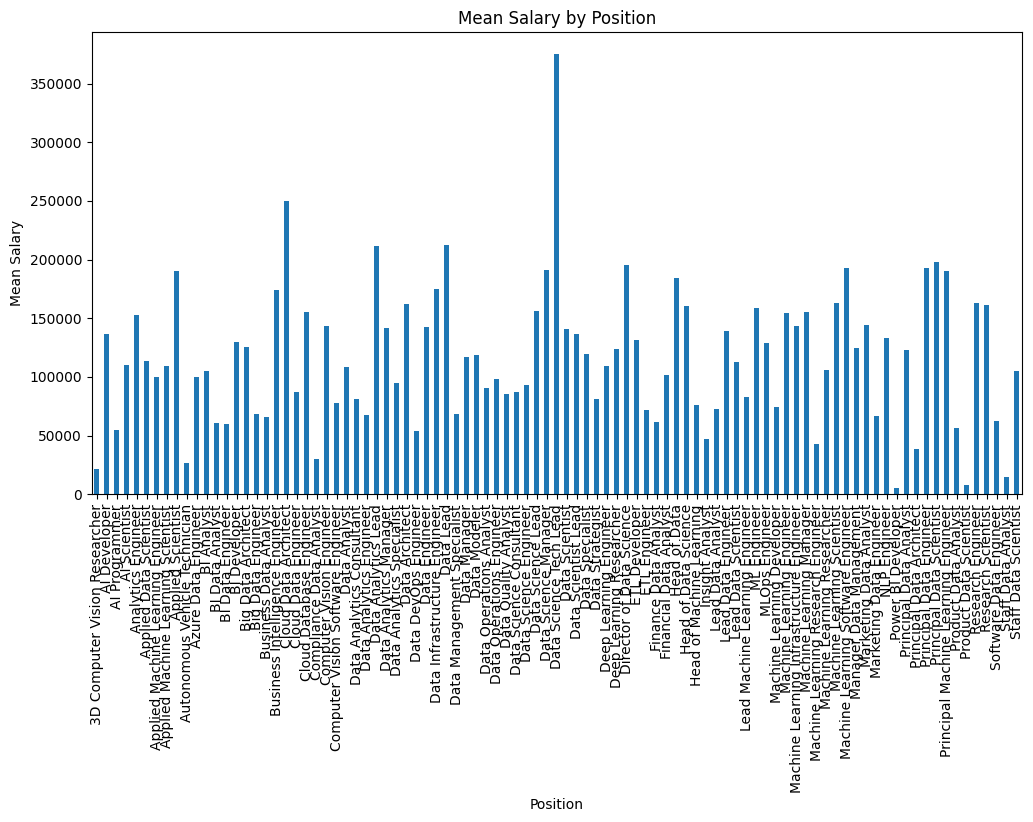

In [4]:
mean_salary_by_position = data.groupby('job_title')['salary_in_usd'].mean()

plt.figure(figsize=(12,6))
mean_salary_by_position.plot(kind='bar')
plt.title('Mean Salary by Position')
plt.xlabel('Position')
plt.ylabel('Mean Salary')
plt.show()

In [5]:
job_title_counts = data['job_title'].value_counts()
job_title_counts.reset_index()

,job_title,count
0,Data Engineer,1040
1,Data Scientist,840
2,Data Analyst,612
3,Machine Learning Engineer,289
4,Analytics Engineer,103
...,...,...
88,Principal Machine Learning Engineer,1
89,Azure Data Engineer,1
90,Manager Data Management,1
91,Marketing Data Engineer,1


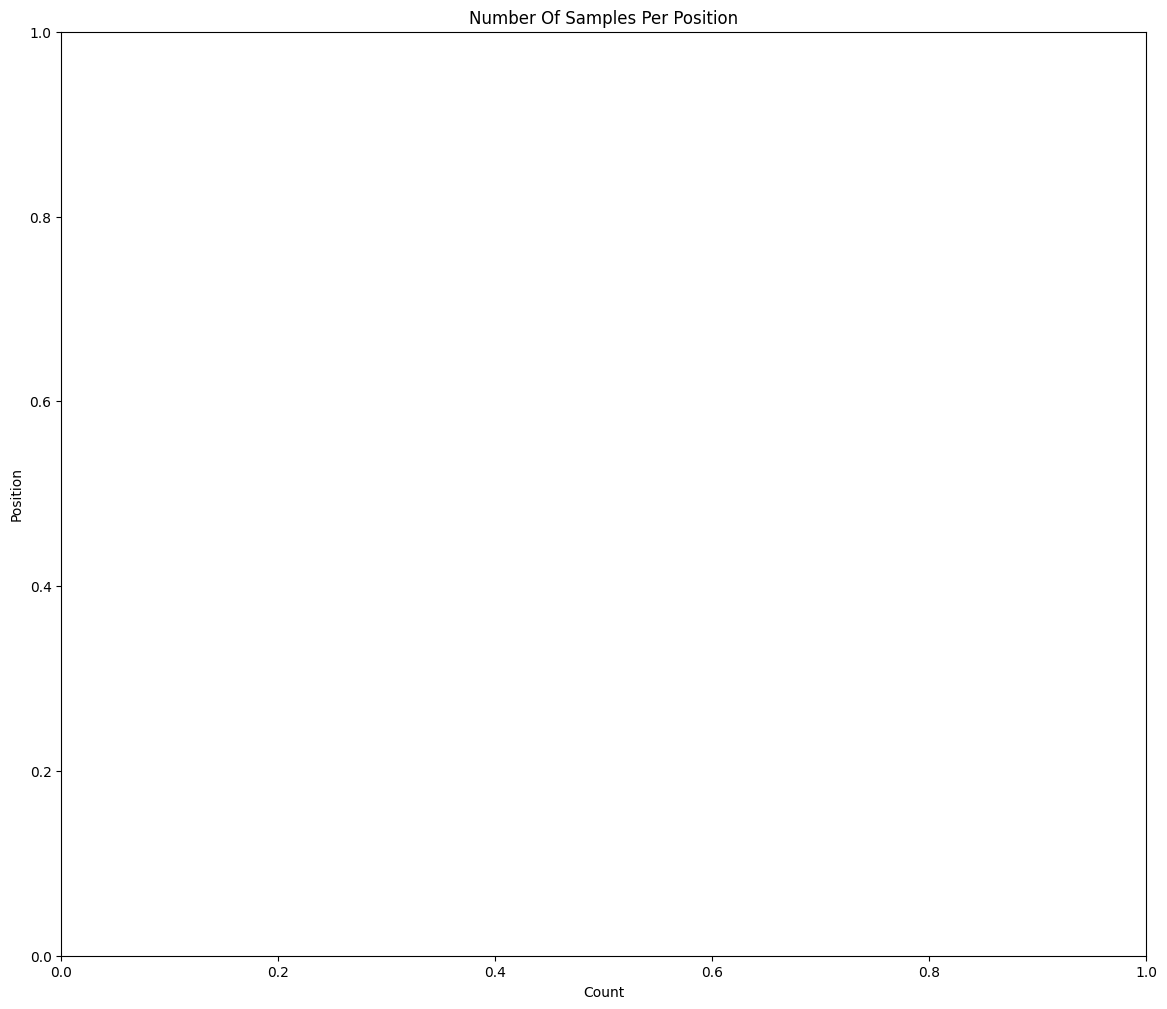

In [6]:
plt.figure(figsize=(14,12))
job_title_counts = data['job_title'].value_counts().reset_index()

#sns.barplot(x='job_title', y='index', data=job_title_counts, palette='viridis')
plt.title('Number Of Samples Per Position')
plt.xlabel('Count')
plt.ylabel('Position')
plt.show()

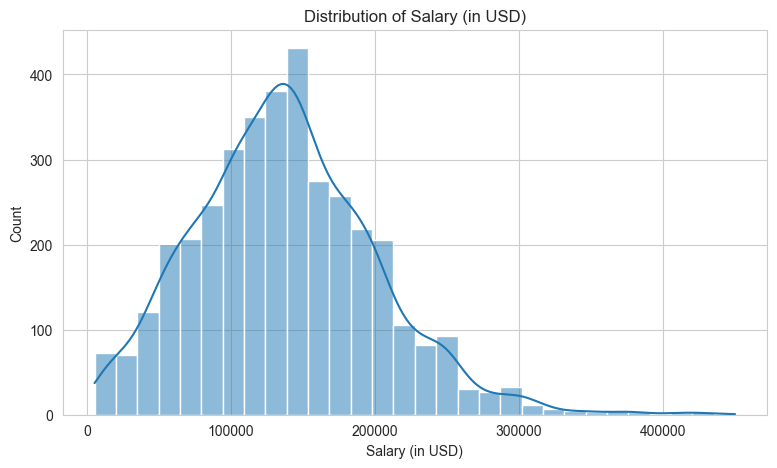

In [7]:
# Set style
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 5))

# Plotting the distribution of salary_in_usd
plt.subplot(1, 2, 1)
sns.histplot(data['salary_in_usd'], kde=True, bins=30)
plt.title('Distribution of Salary (in USD)')
plt.xlabel('Salary (in USD)')
plt.ylabel('Count')

plt.show()

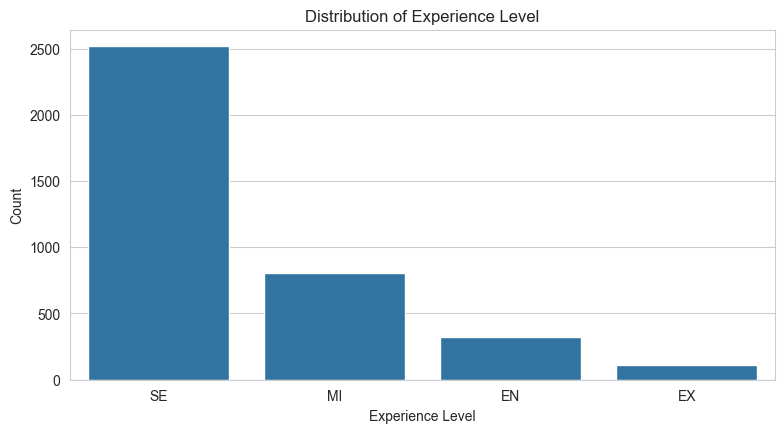

In [8]:
plt.figure(figsize=(20, 10))

# Plotting the distribution of experience_level
plt.subplot(2, 2, 1)
sns.countplot(x='experience_level', data=data, order=data['experience_level'].value_counts().index)
plt.title('Distribution of Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Count')


plt.show()

### Preprocessing
Converting categorical features to numerical using encoding methods

In [9]:
# let's look which features are not numerical and should be converted
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


We can observe that the data set has 7 not numerical features which should be converted:
 experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, and company_size

In [10]:
cols_to_normalize = ['salary', 'salary_in_usd']
data[cols_to_normalize] = data[cols_to_normalize] / 100000

In [11]:
data[cols_to_normalize]

,salary,salary_in_usd
0,0.800,0.85847
1,0.300,0.30000
2,0.255,0.25500
3,1.750,1.75000
4,1.200,1.20000
...,...,...
3750,4.120,4.12000
3751,1.510,1.51000
3752,1.050,1.05000
3753,1.000,1.00000


##### Encoding
Since there are some categorical features, we decided to use Label encoder and One-Hot encoder.
* For features with low number of unique values (as a thumb rule we decided it to be <=20) we used Label encoder.
* for features with high number of unique values we used One-Hot encoder.

In [12]:
# let's inspect the unique values count for each non-numeric column
columns_to_encode = [column for column in data.columns if data[column].dtype == 'object']

for column in columns_to_encode:
    print(column,
          ", ",data[column].nunique())

experience_level ,  4
employment_type ,  4
job_title ,  93
salary_currency ,  20
employee_residence ,  78
company_location ,  72
company_size ,  3


In [13]:
# Extract features and target variable
data_X = data.drop('salary_in_usd', axis=1)
salary_in_usd_Y = data['salary_in_usd']

numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])
# Split the dataset into training and testing sets
x_train, x_rest, y_train, y_rest = train_test_split(data_X, salary_in_usd_Y, train_size=0.6)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

# Apply transformers to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(x_train)
X_valid_preprocessed = preprocessor.transform(x_valid)


### Preparing the Data for training process
* Scaling- using standard scaler
* Train-Test-Validation split

In [14]:
x_train

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
635,2023,SE,FT,Data Scientist,1.863,USD,US,100,US,M
344,2023,SE,FT,Data Engineer,2.220,USD,US,100,US,M
3525,2021,SE,FT,Data Science Engineer,1.595,CAD,CA,50,CA,L
662,2023,EN,FT,Data Analyst,0.700,USD,US,100,US,M
1023,2023,SE,FT,Research Engineer,0.800,EUR,DE,100,DE,S
...,...,...,...,...,...,...,...,...,...,...
3640,2021,MI,FT,Data Scientist,12.500,INR,IN,100,IN,S
821,2023,SE,FT,Data Analyst,0.940,USD,US,100,US,M
2041,2022,EN,FT,Data Analyst,0.500,USD,US,50,US,L
3514,2020,EN,FT,Big Data Engineer,0.700,USD,US,100,US,L


# Modals

## Linear Regression
### Early Stopping

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Building a Linear Regression model with early stopping
linear_regression_early_stopping = Sequential([
    Dense(1, input_shape=(X_train_preprocessed.shape[1],), activation='linear')
])

linear_regression_early_stopping.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              loss='mean_squared_error',  # Mean Squared Error
              metrics=['mae'])  # Track Mean Absolute Error and Mean Squared Error during

# Training the model
linear_history_early_stopping = linear_regression_early_stopping.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2,
                    callbacks=[early_stopping])

linear_evaluation_result_early_stopping = linear_regression_early_stopping.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Epoch 1/400
71/71 - 0s - loss: 1.2939 - mae: 0.9523 - val_loss: 0.8022 - val_mae: 0.7176 - 230ms/epoch - 3ms/step
Epoch 2/400
71/71 - 0s - loss: 0.6476 - mae: 0.6098 - val_loss: 0.4292 - val_mae: 0.4883 - 40ms/epoch - 560us/step
Epoch 3/400
71/71 - 0s - loss: 0.4077 - mae: 0.4707 - val_loss: 0.3083 - val_mae: 0.4152 - 40ms/epoch - 560us/step
Epoch 4/400
71/71 - 0s - loss: 0.3282 - mae: 0.4256 - val_loss: 0.2698 - val_mae: 0.3951 - 41ms/epoch - 576us/step
Epoch 5/400
71/71 - 0s - loss: 0.2972 - mae: 0.4085 - val_loss: 0.2530 - val_mae: 0.3851 - 40ms/epoch - 557us/step
Epoch 6/400
71/71 - 0s - loss: 0.2800 - mae: 0.3969 - val_loss: 0.2425 - val_mae: 0.3778 - 39ms/epoch - 550us/step
Epoch 7/400
71/71 - 0s - loss: 0.2683 - mae: 0.3888 - val_loss: 0.2349 - val_mae: 0.3715 - 39ms/epoch - 556us/step
Epoch 8/400
71/71 - 0s - loss: 0.2598 - mae: 0.3816 - val_loss: 0.2291 - val_mae: 0.3657 - 39ms/epoch - 543us/step
Epoch 9/400
71/71 - 0s - loss: 0.2531 - mae: 0.3768 - val_loss: 0.2250 - val_mae:

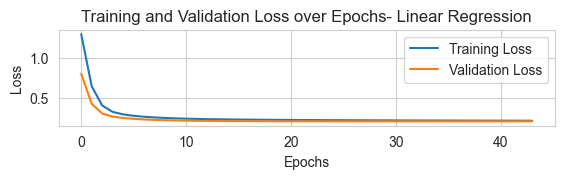

In [16]:
plt.plot(linear_history_early_stopping.history['loss'], label='Training Loss')
plt.plot(linear_history_early_stopping.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs- Linear Regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

### Without Early Stopping 

In [17]:
linear_regression = Sequential([
    Dense(1, input_shape=(X_train_preprocessed.shape[1],), activation='linear')
])

linear_regression.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              loss='mean_squared_error',  # Mean Squared Error
              metrics=['mae'])  # Track Mean Absolute Error and Mean Squared Error during

linear_history = linear_regression.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

linear_evaluation_result = linear_regression.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Epoch 1/400
71/71 - 0s - loss: 0.8700 - mae: 0.7334 - val_loss: 0.5221 - val_mae: 0.5438 - 214ms/epoch - 3ms/step
Epoch 2/400
71/71 - 0s - loss: 0.4525 - mae: 0.4941 - val_loss: 0.3253 - val_mae: 0.4214 - 42ms/epoch - 586us/step
Epoch 3/400
71/71 - 0s - loss: 0.3379 - mae: 0.4296 - val_loss: 0.2777 - val_mae: 0.3972 - 40ms/epoch - 568us/step
Epoch 4/400
71/71 - 0s - loss: 0.3027 - mae: 0.4103 - val_loss: 0.2599 - val_mae: 0.3892 - 39ms/epoch - 556us/step
Epoch 5/400
71/71 - 0s - loss: 0.2851 - mae: 0.3991 - val_loss: 0.2487 - val_mae: 0.3799 - 40ms/epoch - 558us/step
Epoch 6/400
71/71 - 0s - loss: 0.2732 - mae: 0.3887 - val_loss: 0.2405 - val_mae: 0.3739 - 40ms/epoch - 557us/step
Epoch 7/400
71/71 - 0s - loss: 0.2637 - mae: 0.3823 - val_loss: 0.2347 - val_mae: 0.3688 - 40ms/epoch - 557us/step
Epoch 8/400
71/71 - 0s - loss: 0.2568 - mae: 0.3778 - val_loss: 0.2301 - val_mae: 0.3648 - 40ms/epoch - 561us/step
Epoch 9/400
71/71 - 0s - loss: 0.2513 - mae: 0.3723 - val_loss: 0.2267 - val_mae:

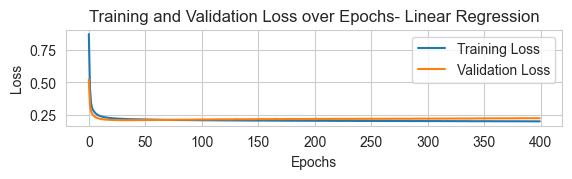

In [18]:
plt.plot(linear_history.history['loss'], label='Training Loss')
plt.plot(linear_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs- Linear Regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

## MLP
### Early Stopping

In [19]:
mlp_model_early_stopping = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_model_early_stopping.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Model summary
mlp_model_early_stopping.summary()

# Train the model with early stopping
mlp_history_early_stopping = mlp_model_early_stopping.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,  # Adjust the number of epochs based on when convergence occurs
                    batch_size=32,  # Adjust batch size according to your dataset size and memory capacity
                    verbose=2,
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
mlp_evaluation_result_early_stopping = mlp_model_early_stopping.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               30720     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

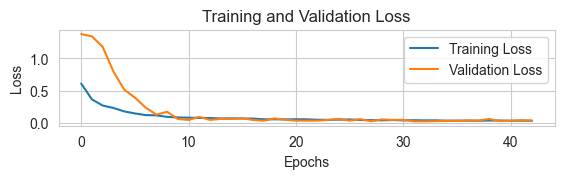

In [20]:
# Plotting the training and validation loss
plt.plot(mlp_history_early_stopping.history['loss'], label='Training Loss')
plt.plot(mlp_history_early_stopping.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

### Without early stopping 

In [21]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Model summary
mlp_model.summary()

mlp_history = mlp_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,  # Adjust the number of epochs based on when convergence occurs
                    batch_size=32,  # Adjust batch size according to your dataset size and memory capacity
                    verbose=2)

# Evaluate the model on the validation set
mlp_evaluation_result = mlp_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               30720     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

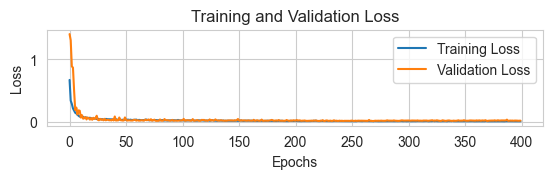

In [22]:
# Plotting the training and validation loss
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.2, bottom=0.0)

plt.show()

### Improve MLP Model With Weight Samples
Dealing with imbalanced data using weight sampels.

In [23]:
for col in data.columns:
  col_counts = data[col].value_counts()
  print(col_counts)

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64
experience_level
SE    2516
MI     805
EN     320
EX     114
Name: count, dtype: int64
employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64
job_title
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: count, Length: 93, dtype: int64
salary
1.00000    112
1.50000    100
1.20000     99
1.60000     85
1.30000     85
          ... 
2.41871      1
0.93919      1
3.85000      1
2.25900      1
4.12000      1
Name: count, Length: 815, dtype: in

In [24]:
job_title_counts = data['job_title'].value_counts()
experience_level_counts = data['experience_level'].value_counts()
employment_type_counts = data['employment_type'].value_counts()

def create_dict_of_weights(col):
  col_counts = data[col].value_counts()
  smallest_class_counts = col_counts.min()
  weights = smallest_class_counts / col_counts
  weights_dict = weights.to_dict()
  print(weights_dict)
  return weights_dict

sample_weights = np.ones(shape=(len(data,)))
cols_to_update_weights = ['job_title', 'experience_level', 'employment_type']
dict_list = []

for col in cols_to_update_weights:
  print(col)
  weights_dict = create_dict_of_weights(col)
  dict_list.append((col, weights_dict))

for col, weights_dict in dict_list:
  sample_weights *= data[col].map(weights_dict).values

print("\n",sample_weights)

job_title
{'Data Engineer': 0.0009615384615384616, 'Data Scientist': 0.0011904761904761906, 'Data Analyst': 0.0016339869281045752, 'Machine Learning Engineer': 0.0034602076124567475, 'Analytics Engineer': 0.009708737864077669, 'Data Architect': 0.009900990099009901, 'Research Scientist': 0.012195121951219513, 'Data Science Manager': 0.017241379310344827, 'Applied Scientist': 0.017241379310344827, 'Research Engineer': 0.02702702702702703, 'ML Engineer': 0.029411764705882353, 'Data Manager': 0.034482758620689655, 'Machine Learning Scientist': 0.038461538461538464, 'Data Science Consultant': 0.041666666666666664, 'Data Analytics Manager': 0.045454545454545456, 'Computer Vision Engineer': 0.05555555555555555, 'AI Scientist': 0.0625, 'BI Data Analyst': 0.06666666666666667, 'Business Data Analyst': 0.06666666666666667, 'Data Specialist': 0.07142857142857142, 'BI Developer': 0.07692307692307693, 'Applied Machine Learning Scientist': 0.08333333333333333, 'Machine Learning Infrastructure Engine

In [25]:
data_X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']

indices = data.index
train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)
X_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
sample_weights_train = sample_weights[train_indices]

numeric_features = data_X.select_dtypes(include=[np.number])
numeric_transformer = StandardScaler()

categorical_features = data_X.select_dtypes(include=['object'])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features.columns),
        ('cat', categorical_transformer, categorical_features.columns)
    ])

indices = data.index
train_indices, valid_indices = train_test_split(indices, test_size=0.3, random_state=42)
x_train, y_train = data_X.loc[train_indices, :], y.loc[train_indices]
sample_weights_train = sample_weights[train_indices]

# Apply transformers to training and testing sets
X_train_preprocessed = preprocessor.fit_transform(x_train)
X_valid_preprocessed = preprocessor.transform(x_valid)
X_test_preprocessed = preprocessor.transform(x_test)

#### MLP Early Stopping With Weight

In [26]:
mlp_weight_model_early_stopping = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_weight_model_early_stopping.compile(optimizer='adam',
              loss='mean_squared_error',  # Use 'mean_squared_error' for regression tasks
              metrics=['mae'])  # Track Mean Absolute Error and Mean Squared Error during training

# Model summary to verify the architecture
mlp_weight_model_early_stopping.summary()

# Train the model
weight_model_history_early_stopping = mlp_weight_model_early_stopping.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2,
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
weight_model_evaluation_result_early_stopping = mlp_weight_model_early_stopping.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               31872     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

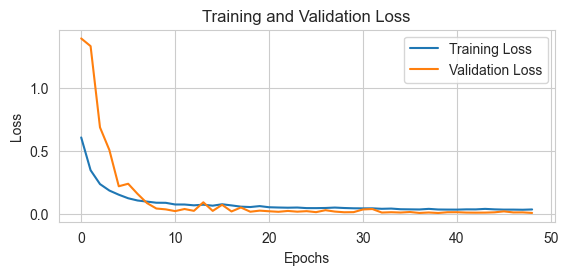

In [27]:
# Plotting the training and validation loss
plt.plot(weight_model_history_early_stopping.history['loss'], label='Training Loss')
plt.plot(weight_model_history_early_stopping.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.4, bottom=0.0)

plt.show()

### MLP With Weight

In [28]:
mlp_weight_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_preprocessed.shape[1]),
    BatchNormalization(),

    # Hidden layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Hidden layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization

    # Output layer: Using 'linear' activation for regression tasks
    Dense(1, activation='linear')
])

# Compile the model
mlp_weight_model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use 'mean_squared_error' for regression tasks
              metrics=['mae'])  # Track Mean Absolute Error and Mean Squared Error during training

# Model summary to verify the architecture
mlp_weight_model.summary()

# Train the model
weight_model_history = mlp_weight_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

# Evaluate the model on the validation set
weight_model_evaluation_result = mlp_weight_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               31872     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                      

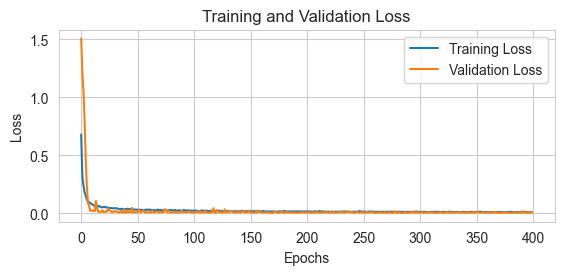

In [29]:
# Plotting the training and validation loss
plt.plot(weight_model_history.history['loss'], label='Training Loss')
plt.plot(weight_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.4, bottom=0.0)

plt.show()

## CNN
### Early Stopping

In [31]:
cnn_model_early_stopping = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(248, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(1)
])

cnn_model_early_stopping.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

cnn_model_early_stopping.summary()

# Train the model
cnn_model_history_early_stopping = cnn_model_early_stopping.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2,
                    callbacks=[early_stopping])

# Evaluate the model on the validation set
cnn_model_evalutaion_result_early_stopping = cnn_model_early_stopping.evaluate(X_valid_preprocessed, y_valid, verbose=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 246, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 60, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 29, 128)          

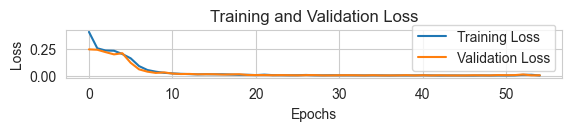

In [32]:
# Plotting the training and validation loss
plt.plot(cnn_model_history_early_stopping.history['loss'], label='Training Loss')
plt.plot(cnn_model_history_early_stopping.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(top=0.1, bottom=0.0)

plt.show()

### Without Early Stopping

In [33]:
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(248, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(1)
])

cnn_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

cnn_model.summary()

# Train the model
cnn_model_history = cnn_model.fit(X_train_preprocessed, y_train,
                    validation_data=(X_valid_preprocessed, y_valid),
                    epochs=400,
                    batch_size=32,
                    verbose=2)

# Evaluate the model on the validation set
cnn_model_evalutaion_result = cnn_model.evaluate(X_valid_preprocessed, y_valid, verbose=0)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 246, 32)           128       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 123, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 121, 64)           6208      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 60, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 29, 128)          

# Conclusions
## Loss and validation loss with early stopping

In [34]:
print(f"Linear Regression model loss is : {linear_history_early_stopping.history['loss'][-1]}\nMLP model loss is: {mlp_history_early_stopping.history['loss'][-1]}\nMLP model with updated weights loss is : {weight_model_history_early_stopping.history['loss'][-1]}\nCNN model loss is: {cnn_model_history_early_stopping.history['loss'][-1]}\n")
print(f"Linear Regression model validation loss is : {linear_history_early_stopping.history['val_loss'][-1]}\nMLP model validation loss is: {mlp_history_early_stopping.history['val_loss'][-1]}\nMLP model with updated weights validation loss is : {weight_model_history_early_stopping.history['val_loss'][-1]}\nCNN model validation loss is: {cnn_model_history_early_stopping.history['val_loss'][-1]}")

Linear Regression model loss is : 0.21878382563591003
MLP model loss is: 0.03652464598417282
MLP model with updated weights loss is : 0.03450325131416321
CNN model loss is: 0.0021434491500258446

Linear Regression model validation loss is : 0.21139191091060638
MLP model validation loss is: 0.038680173456668854
MLP model with updated weights validation loss is : 0.006859037559479475
CNN model validation loss is: 0.004188473802059889


## Loss and validation loss without early stopping

In [35]:
print(f"Linear Regression model loss is : {linear_history.history['loss'][-1]}\nMLP model loss is: {mlp_history.history['loss'][-1]}\nMLP model with updated weights loss is : {weight_model_history.history['loss'][-1]}\nCNN model loss is: {cnn_model_history.history['loss'][-1]}\n")
print(f"Linear Regression model validation loss is : {linear_history.history['val_loss'][-1]}\nMLP model validation loss is: {mlp_history.history['val_loss'][-1]}\nMLP model with updated weights validation loss is : {weight_model_history.history['val_loss'][-1]}\nCNN model validation loss is: {cnn_model_history.history['val_loss'][-1]}")

Linear Regression model loss is : 0.20283851027488708
MLP model loss is: 0.01077019888907671
MLP model with updated weights loss is : 0.010752946138381958
CNN model loss is: 0.0003028774226550013

Linear Regression model validation loss is : 0.226457417011261
MLP model validation loss is: 0.020845722407102585
MLP model with updated weights validation loss is : 0.008431666530668736
CNN model validation loss is: 0.0013466182863339782


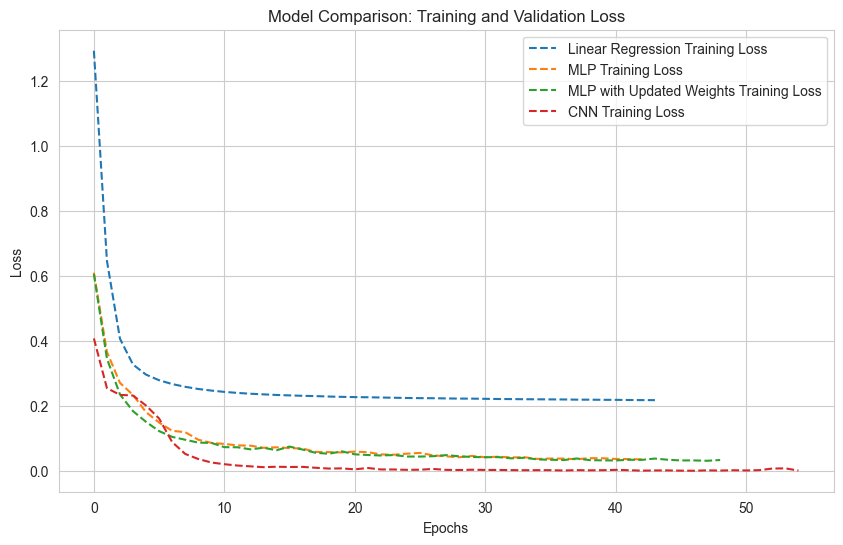

In [38]:
history_objects = [linear_history_early_stopping, mlp_history_early_stopping, 
                   weight_model_history_early_stopping, cnn_model_history_early_stopping]

model_names = ['Linear Regression', 'MLP', 'MLP with Updated Weights', 'CNN']

plt.figure(figsize=(10, 6))
for history, name in zip(history_objects, model_names):
    plt.plot(history.history['loss'], label=f'{name} Training Loss', linestyle='--')

plt.title('Models Comparison: Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

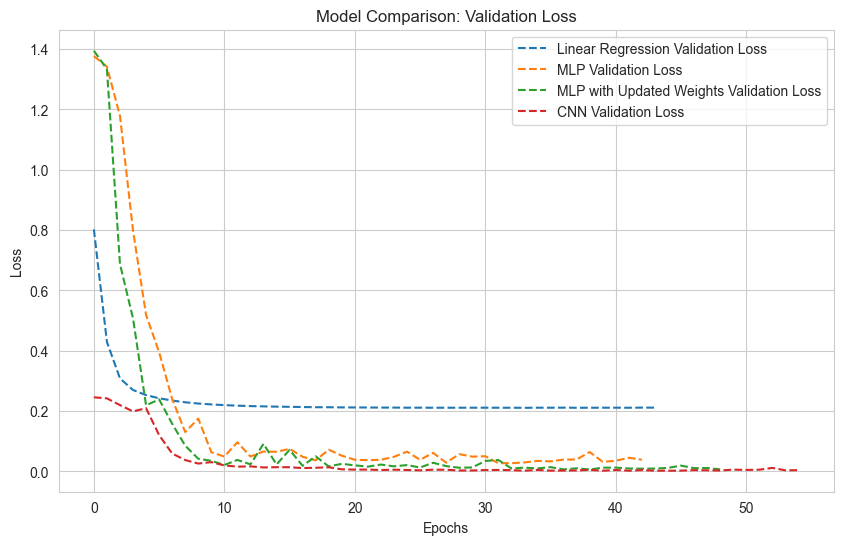

In [40]:
plt.figure(figsize=(10, 6))
for history, name in zip(history_objects, model_names):
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss', linestyle='--')

plt.title('Models Comparison: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
test_loss, test_mae= cnn_model.evaluate(X_test_preprocessed, y_test)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

24/24 [==============================] - 0s 4ms/step - loss: 0.0253 - mae: 0.0280
Test Loss: 0.02531636320054531
Test MAE: 0.027986638247966766
